In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import*
from scipy.integrate import quad

In [2]:
kappas = {'relu': (1/np.sqrt(2*np.pi), 0.5, np.sqrt((np.pi-2)/(4*np.pi))), 
               'erf': (0, 2/np.sqrt(3*np.pi), 0.200364), 'tanh': (0, 0.605706, 0.165576),
               'sign': (0, np.sqrt(2/np.pi), np.sqrt(1-2/np.pi)),
         "id":(0,1,0)}

In [3]:
d=500
k1=700
k2=700

activ="tanh2x"

gamma1=k1/d
gamma2=k2/d


Sigma=np.ones(d)

Delta1=Delta2=Deltaa=1.

Delta=.00



rho0=np.sum(Sigma)/d*Delta1*Delta2*Deltaa
rho1=Delta2*Deltaa
rhoa=Deltaa

print(rho0,rho1,rhoa)


1.0 1.0 1.0


In [4]:
f=lambda x: np.tanh(2*x)#.5*x*(1+np.tanh(np.sqrt(2/np.pi)*(x+0.044715*x**3)))-0.28203858807#np.tanh(2*x)

r1=Delta1*np.mean(Sigma)

k11=quad(lambda x: np.exp(-.5*x**2/r1)*x*f(x)/np.sqrt(2*np.pi*r1),-np.inf,np.inf)[0]/r1


var1=quad(lambda x: np.exp(-.5*x**2/r1)*f(x)**2/np.sqrt(2*np.pi*r1),-np.inf,np.inf)[0]
ks1=np.sqrt(var1-r1*k11**2)

k11,ks1=k11**2,ks1**2

r2=Delta2*var1

k12=quad(lambda x: np.exp(-.5*x**2/r2)*x*f(x)/np.sqrt(2*np.pi*r2),-np.inf,np.inf)[0]/r2


var2=quad(lambda x: np.exp(-.5*x**2/r2)*f(x)**2/np.sqrt(2*np.pi*r2),-np.inf,np.inf)[0]
ks2=np.sqrt(var2-r2*k12**2)

k12,ks2=k12**2,ks2**2



In [5]:
def update_overlaps(qwhat,qahat):
    qa=0
    qw=(Delta1*Delta2*Deltaa)**2*np.mean(qwhat*Sigma**2/(1+qwhat*Delta1*Delta2*Deltaa*Sigma))
    
    return qw,qa

In [7]:
def update_hat_overlaps(alpha,qw,qa):
    qwhat=alpha*k11*k12/(Delta+k12*k11*(rho0-qw)+ks1*k12*rho1+ks2*rhoa)
    qahat=0
    return qwhat,qahat
    
    

In [8]:
damping=0.1

def damp(new, old):
        return (1-damping) * new + damping * old

In [10]:


def iterate(alpha,max_iter=10000,tol=1e-15,init=None,verbose=False):
    last_flip=None
    qw,qa=.000001, .0000001
    qwhat,qahat=0,0
    for i in range(max_iter):
        qwhat,qahat=update_hat_overlaps(alpha,qw,qa)
        qw_tmp,qa_tmp=update_overlaps(qwhat,qahat)
        if max([np.abs(qw_tmp-qw),np.abs(qa_tmp-qa)])<tol:
            if verbose:
                print("convcerged after {} steps".format(i))
            return qw,qa,qwhat,qahat
        
        qw=damp(qw_tmp,qw)
        qa=damp(qa_tmp,qa)
       
        
        if verbose:
            print("qw{} qa{} ".format(qw,qa))
        
        
        
    print(alpha, "Not converged")

    return qw,qa,qwhat,qahat
        
        
        

In [11]:
def get_error(alphas):
    Eg=[]
    Qa=[]
    Qw=[]
    for alpha in alphas:
        qw,qa,qwhat,qahat=iterate(alpha)
        print("alpha {} qw{},  qa{}, qahat{}, qwhat{}".format(alpha,qw,qa,qahat,qwhat))
        eg=k12*k11*(rho0-qw)+ks1*k12*rho1+ks2*rhoa
        Eg.append(eg)
        Qa.append(qa)
        Qw.append(qw)
        
    return Eg,Qa,Qw
        
        
        
        

In [12]:
alphas=np.linspace(.0,7.1,70)
Eg,Qa,Qw=get_error(alphas)

alpha 0.0 qw1.0000000000000005e-16,  qa1.0000000000000005e-17, qahat0, qwhat0.0
alpha 0.10289855072463767 qw0.07337788532548392,  qa1.0000000000000008e-24, qahat0, qwhat0.07918857554059028
alpha 0.20579710144927535 qw0.14339330403219627,  qa1.000000000000001e-27, qahat0, qwhat0.1673968983749181
alpha 0.30869565217391304 qw0.2097493778206021,  qa1.0000000000000011e-30, qahat0, qwhat0.26542133841305143
alpha 0.4115942028985507 qw0.27218210728198994,  qa1.0000000000000013e-32, qahat0, qwhat0.37397006861913806
alpha 0.5144927536231884 qw0.33048062127482597,  qa1.0000000000000014e-34, qahat0, qwhat0.4936087464773496
alpha 0.6173913043478261 qw0.384505777139231,  qa1.0000000000000016e-36, qahat0, qwhat0.6247106193005021
alpha 0.7202898550724637 qw0.4342036429922266,  qa1.0000000000000018e-38, qahat0, qwhat0.7674203582513736
alpha 0.8231884057971014 qw0.47961098582241635,  qa1.0000000000000019e-39, qahat0, qwhat0.9216393366420101
alpha 0.9260869565217391 qw0.5208515141038078,  qa1.00000000000

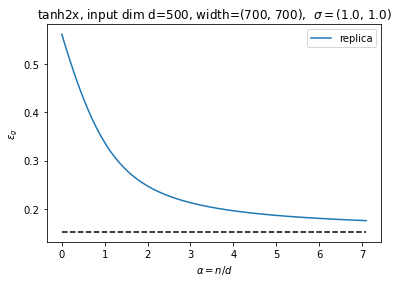

In [14]:
plt.plot(alphas,np.array(Eg), label="replica")



plt.title(r"{}, input dim d={}, width={},  $\sigma=${}".format(activ,d,(k1,k2),(Delta1,Delta2)))
plt.errorbar(alphas,alphas**0*(ks2*rhoa+k12*ks1*rho1),ls="--",c="black")
plt.ylabel(r"$\epsilon_g$")
plt.xlabel(r"$\alpha=n/d$")
plt.legend()
